In [1]:
import re
import os
import pandas as pd
import altair as alt

In [2]:
# define helpers for parsing files, extracting values
def parse_filename(f):
    parts = f.strip().split("_")
    k = parts[1]
    stride = parts[3].split(".")[0]
    return k, stride

def detect_epoch(line, epoch_detector):
    m = epoch_detector.match(line)
    if m is not None:
        return m.groups()[0]
    else:
        return None
    
def detect_macrobatch(line, macrobatch_detector):
    m = macrobatch_detector.match(line)
    return m.groups()[0] if m is not None else None

def detect_loss(line, loss_detector):
    m = loss_detector.match(line)
    return m.groups()[0] if m is not None else None

In [3]:
# define the REs for extracting values
epoch_detector = re.compile('.*epoch\ (\d+)')
macrobatch_detector = re.compile('.*macrobatch\ (\d+)')
loss_detector = re.compile('.*loss: (\d+\.\d+)')

In [6]:
# get list of files
txt_files = [f for f in os.listdir(os.path.expanduser("~/projects/embedding/results/debug_output")) if f.endswith('filtered.txt')]

# build df in tidy-data fashion
dfs = []

In [7]:
for fname in txt_files:
    K, stride = parse_filename(fname)
    loss_list = []
    macrobatch_list = []
    epoch_list = []
    my_f = open(os.path.join(os.path.expanduser("~/projects/embedding/results/debug_output"),fname), encoding='utf-8')
    for line in my_f:
        # scrape the data
        line = line.strip()
        e = detect_epoch(line, epoch_detector)
        if e is not None:
            epoch_list.append(e)
        m = detect_macrobatch(line, macrobatch_detector)
        if m is not None:
            macrobatch_list.append(m)
        l = detect_loss(line, loss_detector)
        if l is not None:
            loss_list.append(l)
    my_f.close()
    
    # construct the DF
    replen = max([int(m) for m in macrobatch_list])
    el = [[int(e) for i in range(replen + 1)]for e in epoch_list]
    try:
        ll = len(loss_list)
        lel = len([int(item) for sublist in el for item in sublist])
        lm = len(macrobatch_list)
        assert(ll == lel == lm)
    except AssertionError:
        print("Problem in ", fname)
        print("List length mismatch: losses have ", ll, " elements, epochs have ", lel, " elements, macrobatches have ", lm," elements.")
    this_df = pd.DataFrame.from_items([('K', [int(K) for i in range(len(loss_list))]),('stride', [int(stride) for i in range(len(loss_list))]),('epoch', [int(item) for sublist in el for item in sublist]),('macrobatch', [int(m) for m in macrobatch_list]),('loss',[float(l) for l in loss_list])], orient='columns')    
    dfs.append(this_df)   


Problem in  k_8_s_1.filtered.txt
List length mismatch: losses have  295  elements, epochs have  300  elements, macrobatches have  295  elements.


ValueError: arrays must all be same length

In [ ]:
# put into one df, build the figure
my_df = pd.concat(dfs)        

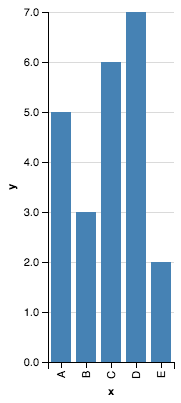

In [5]:
chart.display()